In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn.pipeline import Pipeline
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
import itertools
import warnings
warnings.filterwarnings("ignore")

In [2]:
def getListOfFiles(dirName, quantity=None):
    # create a list of file and sub directories 
    # names in the given directory
    files = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    if not quantity:
        for file in files:
            # Create full path
            fullPath = dirName + "\\" + file
            # If entry is a directory then get the list of files in this directory 
            if os.path.isdir(fullPath) and not quantity:
                allFiles = allFiles + getListOfFiles(fullPath)
            else:
                allFiles.append(fullPath)
    else:
        allFiles = allFiles + getListOfFiles(dirName)[:quantity]
    return allFiles

def create_corpus(file):
    corpus=[]
    f = open (file,'r', encoding="utf8")
    corpus=f.read()
    return corpus


cant_letters=2
def normalize(s):
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for a, b in replacements:
        s = s.replace(a, b)
    return s

def limpieza_curacion(file):
    
    tokenizer = RegexpTokenizer(r'\w+')
    tokens=tokenizer.tokenize(file)

    tokens_normalize = [normalize(word) for word in tokens if word.isalpha()]

    tokens_normalize=[token for token in tokens_normalize if len(token) > cant_letters]

    words = [token for token in tokens_normalize if token not in STOPWORDS]


    spanish_stemmer = SnowballStemmer('spanish')
    tokens_stemm=[spanish_stemmer.stem(word) for word in words]
    return words

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta correcta')
    plt.xlabel('Etiqueta predicha')
    
def graph_frequency(dataframe):
    plt.figure(figsize=(10,6))
    sns.barplot(x=dataframe[:15].Token, y=dataframe[:15].Frecuencia, color='skyblue')
    plt.xticks(rotation=90)
    sns.despine()

def obtain_tokens_and_dataframe(corpus):
    tokens=[t for t in corpus.split()]
    freq = nltk.FreqDist(tokens)
    data = pd.DataFrame(freq.items(), columns=['Token', 'Frecuencia']).sort_values(by="Frecuencia", ascending=False)
    return data

def get_idf_stopwords(data):
    transformer = TfidfVectorizer(ngram_range=(1,1))
    tfidf = transformer.fit(data)
    df_tfidf = pd.DataFrame(transformer.idf_,columns=["idf_"])
    df_tfidf.insert(0,'palabra',tfidf.vocabulary_.keys())
    data_w_lower_idf=df_tfidf[df_tfidf['idf_'] < df_tfidf['idf_'].quantile(0.20)]
    return data_w_lower_idf

In [3]:

fueros=['FAMILIA', 'LABORAL', 'MENORES', 'PENAL']
root=os.getcwd()
dirname=f'{root}\\Documentos'
files=getListOfFiles(dirname)

In [4]:
import nltk
dirname= "Corpus.txt"

f = open (dirname,'r', encoding="utf-8")
corpus=f.read()
f.close
corpus= corpus.lower()
data=obtain_tokens_and_dataframe(corpus)
data

,Token,Frecuencia
6,de,82491
59,la,58221
52,que,40215
87,el,35123
75,en,33032
...,...,...
34699,abonadas-,1
34698,09);,1
34697,(octubre,1
34696,(13.08.09),1


In [5]:

data= pd.DataFrame(files, columns=['file'])
data['fuero']= data['file'].apply(lambda x: x.split('\\')[-2])
data['texto']= data['file'].apply(lambda x: create_corpus(x))
data['fuero'].value_counts()

FAMILIA    124
PENAL       53
LABORAL     37
MENORES     29
Name: fuero, dtype: int64

In [6]:
data

,file,fuero,texto
0,C:\Users\Usuario\Mentoria_Busqueda_y_Recomenda...,FAMILIA,"AUTO:122, t. 2 f.547/552\n\nCórdoba, veinticua..."
1,C:\Users\Usuario\Mentoria_Busqueda_y_Recomenda...,FAMILIA,"AUTO n.º 3.\nCórdoba, nueve de febrero de dos ..."
2,C:\Users\Usuario\Mentoria_Busqueda_y_Recomenda...,FAMILIA,DATOS DE LA CAUSA\nSede: Ciudad de Córdoba.\nD...
3,C:\Users\Usuario\Mentoria_Busqueda_y_Recomenda...,FAMILIA,Cámara de Familia de 2ª Nominación de Córdoba\...
4,C:\Users\Usuario\Mentoria_Busqueda_y_Recomenda...,FAMILIA,"\nAUTO n.º 164 de fecha 15/11/2016\nCórdoba, q..."
...,...,...,...
238,C:\Users\Usuario\Mentoria_Busqueda_y_Recomenda...,PENAL,SALA PENAL - TRIBUNAL SUPERIOR\n\nProtocolo de...
239,C:\Users\Usuario\Mentoria_Busqueda_y_Recomenda...,PENAL,SALA PENAL - TRIBUNAL SUPERIOR\n\nProtocolo de...
240,C:\Users\Usuario\Mentoria_Busqueda_y_Recomenda...,PENAL,SALA PENAL - TRIBUNAL SUPERIOR\n\nProtocolo de...
241,C:\Users\Usuario\Mentoria_Busqueda_y_Recomenda...,PENAL,SALA PENAL - TRIBUNAL SUPERIOR\n\nProtocolo de...


In [7]:
tokenizer = RegexpTokenizer(r'\w+')
file_stopwords='stopwords.txt'
f = open (file_stopwords,'r', encoding="utf-8")
stopwords_list=f.read()
stopwords_tokens_list=tokenizer.tokenize(stopwords_list)
stopwords_tokens=stopwords.words('spanish')
stopwords_tokens.extend(stopwords_tokens_list)
data_w_lower_idf=get_idf_stopwords(data['texto'])
stopwords_tokens.extend(data_w_lower_idf.palabra.values) #Aca se agregar los nuevos stopwords
STOPWORDS =set([normalize(word.lower()) for word in stopwords_tokens])



data['texto']= data['texto'].apply(lambda x: ' '.join(limpieza_curacion(x)))

In [8]:
vectorizer = TfidfVectorizer()
transform = vectorizer.fit(data['texto'])
X,Y=transform.transform(data['texto']), data['fuero']

### Non-negative Matrix Factorization

 La forma en que funciona NMF, es que descompone (o factoriza) vectores de alta dimensión en una representación de menor dimensión. Estos vectores de menor dimensión no son negativos, lo que también significa que sus coeficientes no son negativos.
Usando la matriz original (X), NMF le dará dos matrices (W y H). W son los temas que encontró y H son los coeficientes (ponderaciones) para esos temas. En otras palabras, X son artículos por palabras (originales), H son artículos por temas y W son temas por palabras.

Para la discusión en este documento, asumiremos que X está configurado para que haya n puntos de datos, cada uno con p dimensiones, y cada columna de X es un punto de datos

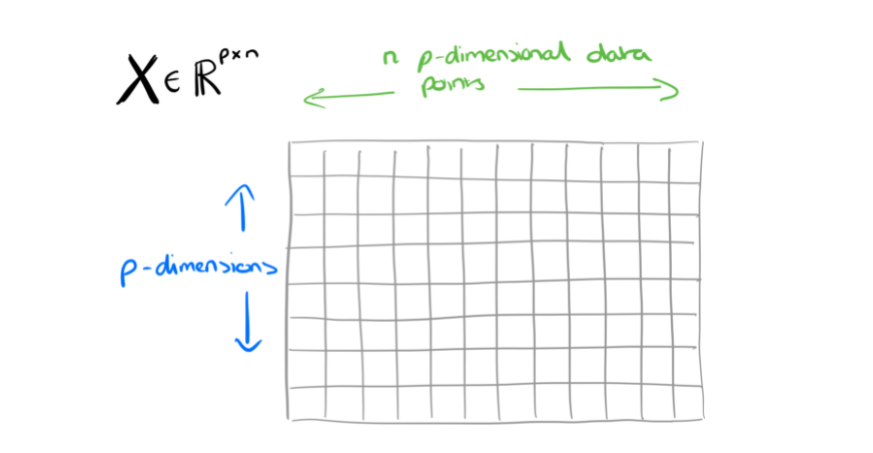

Queremos reducir las p dimensiones originales a r(también conocido como crear una r aproximación de rango ). 

La interpretación de W es que cada columna es un elemento base . Por elemento base nos referimos a algún componente que aparece una y otra vez en todos los nortepuntos de datos originales. Estos son los bloques de construcción fundamentales a partir de los cuales podemos reconstruir aproximaciones a todos los puntos de datos originales.

La interpretación de H es que cada columna da las 'coordenadas de un punto de datos' en la base W. En otras palabras, le dice cómo reconstruir una aproximación al punto de datos original a partir de una combinación lineal de los bloques de construcción en W

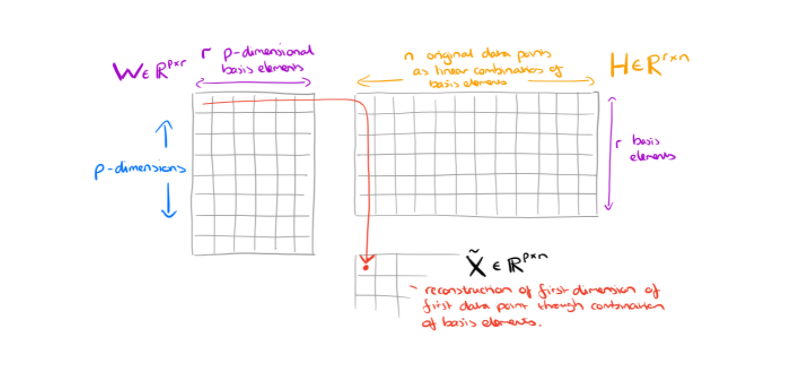

La razón por la que el NMF se ha vuelto tan popular es su capacidad para extraer automáticamente factores escasos y fácilmente interpretables.

In [9]:
from sklearn.decomposition import NMF
nmf_model = NMF(n_components=4,random_state=42)


A la hora de instanciar el modelo, probamos con diferentes parametros en el atributo init, que era el que mas sentido nos hacia probar y que hace referencia a que metodo se va a utilizar para iniciar el procedimiento de la factorizacion. Pudimos observar que dejando la clase con ese parametro por default nos daba mejores resultados, pero es un punto a tener en cuenta, ya que ese parametro se adapta de diferente forma de acuerdo a los datasets. En la documentacion https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html hay mas detalles al respecto

In [10]:
%%time
nmf_model.fit(X)

Wall time: 194 ms


NMF(n_components=4, random_state=42)

La ejecucion es bastante rapida, no superando nunca los 240 milisegundos

In [11]:
for i in range(4):
    topico = nmf_model.components_[i]
    print(f'\n15 Palabras más comunes del Tópico {i + 1}')
    print([vectorizer.get_feature_names()[i] for i in topico.argsort()[-25:]])


15 Palabras más comunes del Tópico 1
['aumento', 'progenitor', 'prueba', 'auto', 'autos', 'pago', 'necesidades', 'pesos', 'señor', 'divorcio', 'ingresos', 'mil', 'costas', 'gastos', 'señora', 'hijos', 'agravios', 'ley', 'familia', 'alimentante', 'apelante', 'alimentos', 'fecha', 'recurso', 'apelacion']

15 Palabras más comunes del Tópico 2
['pago', 'pronuncio', 'antecede', 'por', 'cuestion', 'lct', 'despido', 'voto', 'indemnizacion', 'sala', 'ley', 'señor', 'laboral', 'nro', 'eugenio', 'doctor', 'expediente', 'enrique', 'arabel', 'mercedes', 'blanc', 'angulo', 'vocal', 'rubio', 'luis']

15 Palabras más comunes del Tópico 3
['civil', 'equipo', 'cuidado', 'adolescencia', 'madre', 'informe', 'adolescente', 'autos', 'hija', 'relacion', 'situacion', 'proteccion', 'excepcional', 'ley', 'medida', 'guarda', 'familiar', 'niñez', 'senaf', 'sra', 'derechos', 'adopcion', 'familia', 'niña', 'niño']

15 Palabras más comunes del Tópico 4
['maria', 'voto', 'recurso', 'superior', 'aida', 'delito', 'ju

Si forzamos al metodo a dividir el fuero en 4 clases, podemos ver en los resultados que las diferencia bien, pudiendo identificar los 4 fueros con los cuales venimos trabajando.
Quizas entre el topico 1 y el 3 es donde hay menos diferencia ya que se pueden catalogar como familia o menores

In [12]:
predictions_for_file=nmf_model.transform(X)
fuero_keys={'0':'FAMILIA', '1':'LABORAL','2':'MENORES', '3':'PENAL'}

y_real= data['fuero']
predictions=[predictions_for_file[i].argmax() for i in range(len(predictions_for_file))]
predic=[fuero_keys[str(prediction)] for prediction in predictions]
predic[:5]



['MENORES', 'FAMILIA', 'MENORES', 'FAMILIA', 'FAMILIA']

Accuracy: 0.88
F1 score: 0.88


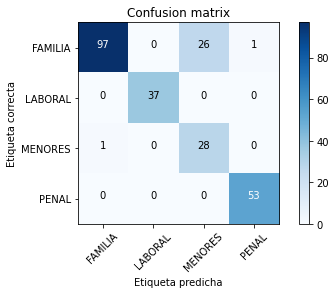

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
cm = confusion_matrix(y_real, predic, labels=['FAMILIA', 'LABORAL', 'MENORES', 'PENAL'])
plot_confusion_matrix(cm, ['FAMILIA', 'LABORAL', 'MENORES', 'PENAL'])
print("Accuracy:", round(accuracy_score(y_real, predic), 2))
print("F1 score:", round(f1_score(y_real, predic, average='macro'),2))

Haciendo un mapeo entre los archivos de los cuales ya sabemos a que fuero pertenecen y lo que predijo el modelo podemos obtener una intuicion de que tambien clasifico o agrupo NMF a los documentos. Podemos ver que el accuracy y el F1 dieron muy buenos resultados y en la matriz de confusion se puede observar que la mayoria de los errores estuvo entre los fueros de Familia y Menores, algo que intuiamos.
    

### Latent Dirichlet Allocation (LDA)

Latent Dirichlet Allocation (LDA) es un método de aprendizaje automático no supervisado, generativo y no parametrizado.
Se basa en un concepto matemático probabilístico directo de la inferencia bayesiana.
La inferencia bayesiana es una forma de obtener predicciones más precisas de sus datos. 
Es particularmente útil cuando no tenemos tantos datos como nos gustaría y deseamos aprovechar hasta el último bit predictivo. 

En LDA, cada documento puede verse como una mezcla de varios temas en los que se considera que cada documento tiene un conjunto de temas que se le 
asignan a través de LDA. Esto es idéntico al análisis semántico latente 
probabilístico (pLSA), excepto que en LDA se supone que la distribución de 
los temas tiene una distribución previa de Dirichlet. Los escasos antecedentes de Dirichlet intuyen que los documentos cubren solo un pequeño conjunto de 
temas y que los temas usan solo un pequeño conjunto de palabras con frecuencia. En la práctica, esto da como resultado una mejor desambiguación 
de las palabras y una asignación más precisa de los documentos a los temas. 


Por ejemplo, un modelo LDA puede tener temas que se pueden clasificar como gato y perro. El primero tiene probabilidades de 
generar varias palabras, como leche, miau y gatito, que el espectador puede clasificar e interpretar como gato. Naturalmente, la palabra 
gato en sí tendrá una alta probabilidad dado este tema. El tema perro también tiene 
probabilidades de generar palabras como: cachorro, ladrido y hueso que pueden tener una alta probabilidad. Las palabras sin relevancia especial, como "la",
tendrán una probabilidad más o menos uniforme entre las clases (o se pueden colocar en una categoría separada). Un tema no está ni semántica ni 
epistemológicamente definido. Se identifica sobre la detección automática de la probabilidad de ocurrencia simultánea de términos. Sin embargo, una palabra 
léxica puede aparecer en varios temas con una probabilidad diferente, con un conjunto típico diferente de palabras vecinas de cada tema.

In [14]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

vectorizer = TfidfVectorizer()
transform = vectorizer.fit(data['texto'])
X,Y=transform.transform(data['texto']), data['fuero']

lda_model = LDA(n_components=4,random_state=42, n_jobs=-1)

In [15]:
%%time
lda_model.fit(X)

Wall time: 2.68 s


LatentDirichletAllocation(n_components=4, n_jobs=-1, random_state=42)

Con respecto a los tiempos, si bien es muy rapido el procedimiento, podemos decir que LDA demora un poco mas que NMF

In [16]:
for i in range(4):
    topico = lda_model.components_[i]
    print(f'\n25 Palabras más comunes del Tópico {i + 1}')
    print([vectorizer.get_feature_names()[i] for i in topico.argsort()[-25:]])


25 Palabras más comunes del Tópico 1
['sopesarse', 'renanco', 'sacifia', 'prosecretario', 'aramburu', 'encarnacion', 'huinca', 'buzzacchi', 'matrimoniales', 'cilley', 'turbado', 'perlbach', 'saludables', 'ottogalli', 'aicardi', 'mobiliario', 'volviendo', 'preferencias', 'restituyan', 'entornos', 'adaptables', 'recepcionadas', 'casco', 'carasso', 'accesibles']

25 Palabras más comunes del Tópico 2
['prosecretario', 'encarnacion', 'sacifia', 'buzzacchi', 'renanco', 'huinca', 'turbado', 'cilley', 'sopesarse', 'matrimoniales', 'aramburu', 'perlbach', 'saludables', 'aicardi', 'ottogalli', 'mobiliario', 'volviendo', 'preferencias', 'restituyan', 'entornos', 'casco', 'adaptables', 'accesibles', 'carasso', 'recepcionadas']

25 Palabras más comunes del Tópico 3
['agravios', 'cuestion', 'derechos', 'sala', 'costas', 'apelante', 'caso', 'luis', 'mil', 'niña', 'autos', 'penal', 'por', 'nro', 'señora', 'señor', 'expediente', 'tribunal', 'vocal', 'niño', 'apelacion', 'familia', 'fecha', 'recurso', 

*Al utilizar LDA con la vectorizacion de tfidf, podemos ver que los tópicos 1 y 2 son prácticamente iguales.*

Ahora vamos a probar con otro algoritmo de vectorizacion para comprobar si esta tendencia en los tópicos cambia.

In [17]:
vectorizer = CountVectorizer()
transform = vectorizer.fit(data['texto'])
X,Y=transform.transform(data['texto']), data['fuero']

In [18]:
lda_model = LDA(n_components=4,random_state=42, n_jobs=-1)

In [19]:
%%time
lda_model.fit(X)

Wall time: 1.91 s


LatentDirichletAllocation(n_components=4, n_jobs=-1, random_state=42)

In [20]:
for i in range(4):
    topico = lda_model.components_[i]
    print(f'\n25 Palabras más comunes del Tópico {i}')
    print([vectorizer.get_feature_names()[i] for i in topico.argsort()[-25:]])


25 Palabras más comunes del Tópico 0
['maria', 'caso', 'casacion', 'doctor', 'superior', 'inc', 'justicia', 'vta', 'señora', 'luis', 'voto', 'juicio', 'señor', 'cuestion', 'recurso', 'imputado', 'pena', 'por', 'ley', 'sala', 'tribunal', 'vocal', 'penal', 'nro', 'expediente']

25 Palabras más comunes del Tópico 1
['por', 'años', 'asi', 'publica', 'registro', 'maria', 'ordoñez', 'escribano', 'gastaldi', 'daniel', 'notarial', 'penal', 'caso', 'tribunal', 'lascano', 'allende', 'pena', 'hechos', 'escritura', 'gabarro', 'nro', 'scudieri', 'expediente', 'pace', 'vta']

25 Palabras más comunes del Tópico 2
['hija', 'audiencia', 'civil', 'caso', 'vida', 'madre', 'informe', 'mil', 'niñez', 'guarda', 'proteccion', 'fecha', 'que', 'adopcion', 'medida', 'relacion', 'situacion', 'familiar', 'autos', 'sra', 'ley', 'derechos', 'niña', 'familia', 'niño']

25 Palabras más comunes del Tópico 3
['auto', 'codigo', 'juez', 'quo', 'alimentos', 'hijos', 'honorarios', 'prueba', 'civil', 'corresponde', 'por', 

*Lo que podemos ver es que los tópicos no se repiten como en caso anterior.*

Pero aun así no podemos asegurar que cada tópico genere clases validas de agrupación de los documentos. 

In [21]:
predictions_for_file=lda_model.transform(X)
fuero_keys={'0':'PENAL', '1':'LABORAL','2':'MENORES', '3':'FAMILIA'}

y_real= data['fuero']
predictions=[predictions_for_file[i].argmax() for i in range(len(predictions_for_file))]
predic=[fuero_keys[str(prediction)] for prediction in predictions]
predic[:5]


['FAMILIA', 'FAMILIA', 'MENORES', 'FAMILIA', 'FAMILIA']

Accuracy: 0.77
F1 score: 0.6


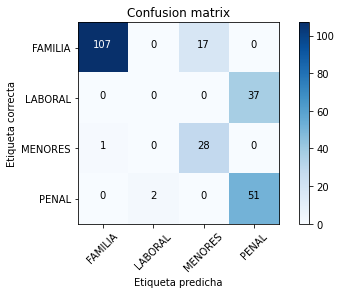

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
cm = confusion_matrix(y_real, predic, labels=['FAMILIA', 'LABORAL', 'MENORES', 'PENAL'])
plot_confusion_matrix(cm, ['FAMILIA', 'LABORAL', 'MENORES', 'PENAL'])
print("Accuracy:", round(accuracy_score(y_real, predic), 2))
print("F1 score:", round(f1_score(y_real, predic, average='macro'),2))

Con LDA no pudimos obtener los mismos resultados que con NMF pero siguen siendo relativamente buenos. En la matriz de confusion vemos nuevamente que se confunden los archivos de familia y menores. Y en el caso de los archivos de laboral, no predice ninguno como tal, si no que los predice a todos como penal.

### Conclusiones

Como parte del trabajo practico de Aprendizaje No supervisado pudimos observar 2 tecnicas diferentes para encontrar topicos como son NMF y LDA, y algunas conclusiones o aspectos relevantes que encontramos fueron:
- Ambos metodos son muy veloces en cuanto a procesamiento ya que se ejecutaron muy rapido, siendo NMF un poco mas rapido
- Se ejecutaron con la premisa de que habia 4 topicos, para poder evaluar si habia una correspondencia con los fueros que conociamos a priori de cada documento, pero al ejecutarlo para mas topicos, por ejemplo 10, se pudo observar que se hacia una diferenciacion de tema mucho mas especifica dentro de cada fuero, algo bastante interesante y que denotaba que al menos NMF funcionaba muy bien
- En cuanto a los resultados vimos que si bien ambos metodos funcionan de forma mas que aceptable, NMF tiene una mejor discriminacion de topicos, o mas acorde a la clasificacion a priori que teniamos de cada documento